In [1]:
import numpy as np
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns

from sys import stderr

from typing import Dict
from numpy import typing as npt

In [2]:
def read_chains(filename: str) -> Dict[str, npt.NDArray]:
    try:
        with open(filename, "r") as f:
            chains = dict()
            for line in f.readlines():
                name, *data = line.split()
                chains[name] = np.array(list(map(float, data)))
            return chains
    except IOError as e:
        print(f"{e}", file=stderr)
        return dict()

In [3]:
chains_hc_1  = read_chains("../tf2_chains_hc_1.txt")
chains_hc_2  = read_chains("../tf2_chains_hc_2.txt")
chains_no_hc = read_chains("../tf2_chains.txt")

# Wasserstein distance from original model to target model

In [4]:
N_DATA = 1000

p0, p1, p2 = 0.5, 0.45, 0.05
assert p0 + p1 + p2 == 1.0

m0, m1, m2 = 0.0, 0.75, 3.0
sd = 0.2

In [5]:
def orig_model():
    data = np.ndarray(shape=(N_DATA))
    for i in range(N_DATA):
        choice = np.random.uniform(0.0, 1.0)
        if (choice <= p0):
            data[i] = np.random.normal(m0, sd)
        elif (choice <= p0 + p1):
            data[i] = np.random.normal(m1, sd)
        else:
            data[i] = np.random.normal(m2, sd)

    return data

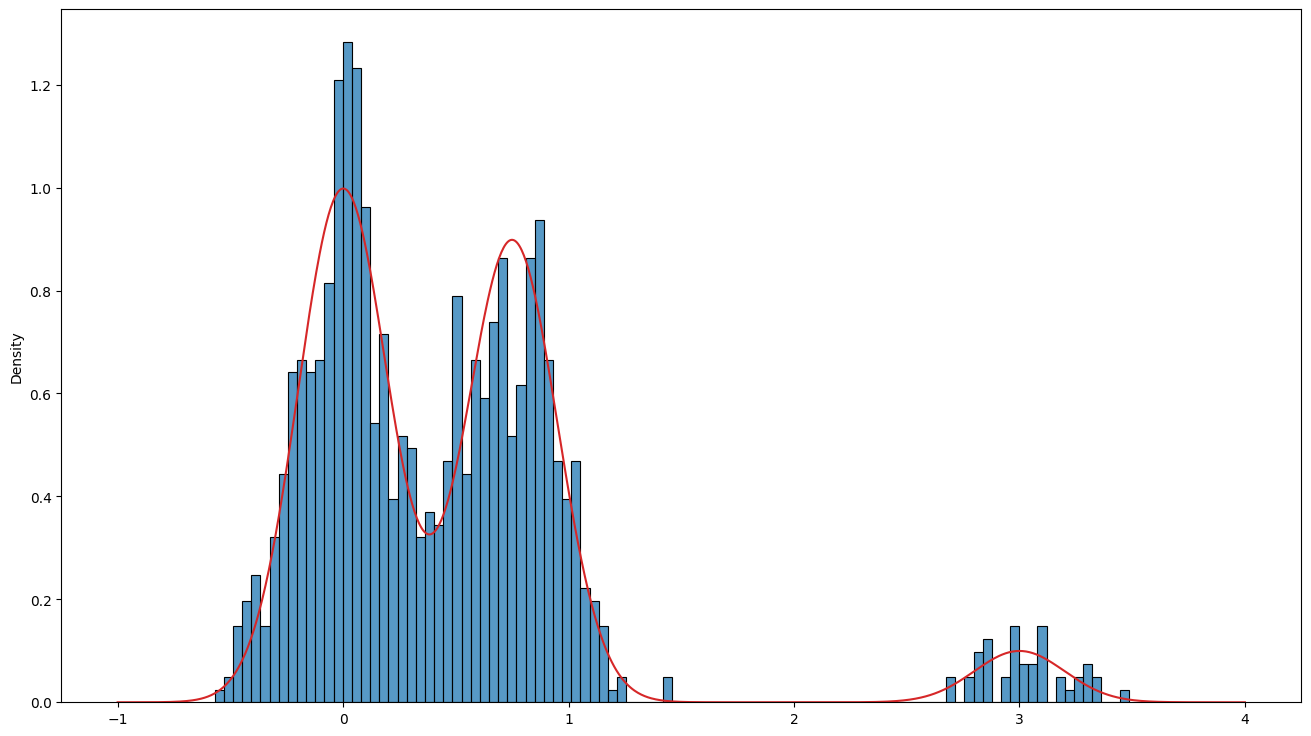

In [6]:
data = orig_model()

plt.figure(figsize=(16, 9))

sns.histplot(data, stat="density", bins=100)

x = np.linspace(-1.0, 4.0, 1000)
y = p0 * stats.norm.pdf(x, m0, sd) + p1 * stats.norm.pdf(x, m1, sd) + p2 * stats.norm.pdf(x, m2, sd)
plt.plot(x, y, color="tab:red")

plt.show()

In [7]:
def target_model(rho, mu):
    data = np.ndarray(shape=(N_DATA))
    for i in range(N_DATA):
        choice = np.random.uniform(0.0, 1.0)
        if (choice <= (1-rho)):
            data[i] = np.random.normal(0.0, sd)
        else:
            data[i] = np.random.normal(mu, sd)

    return data

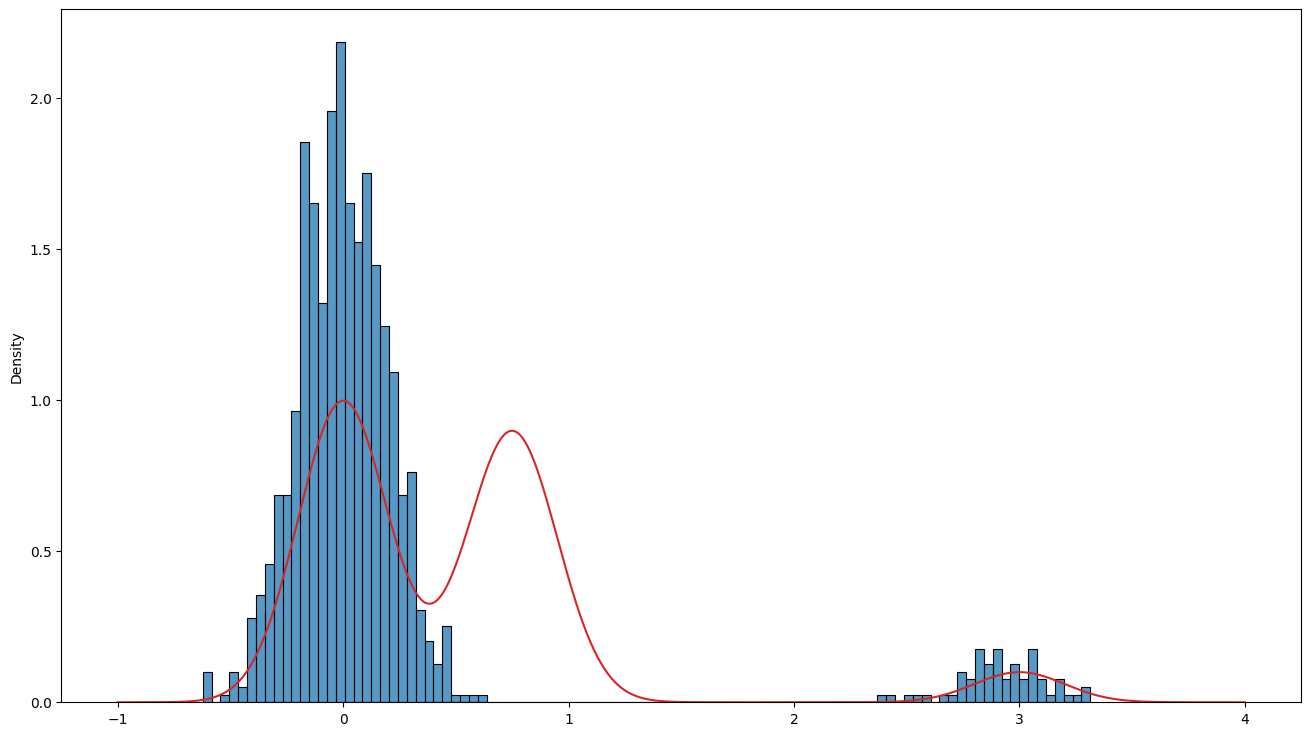

In [8]:
data_mean_hc1 = target_model(rho=np.mean(chains_hc_1['theta0']), mu=np.mean(chains_hc_1['theta1']))

plt.figure(figsize=(16, 9))

sns.histplot(data_mean_hc1, stat="density", bins=100)

x = np.linspace(-1.0, 4.0, 1000)
y = p0 * stats.norm.pdf(x, m0, sd) + p1 * stats.norm.pdf(x, m1, sd) + p2 * stats.norm.pdf(x, m2, sd)
plt.plot(x, y, color="tab:red")

plt.show()

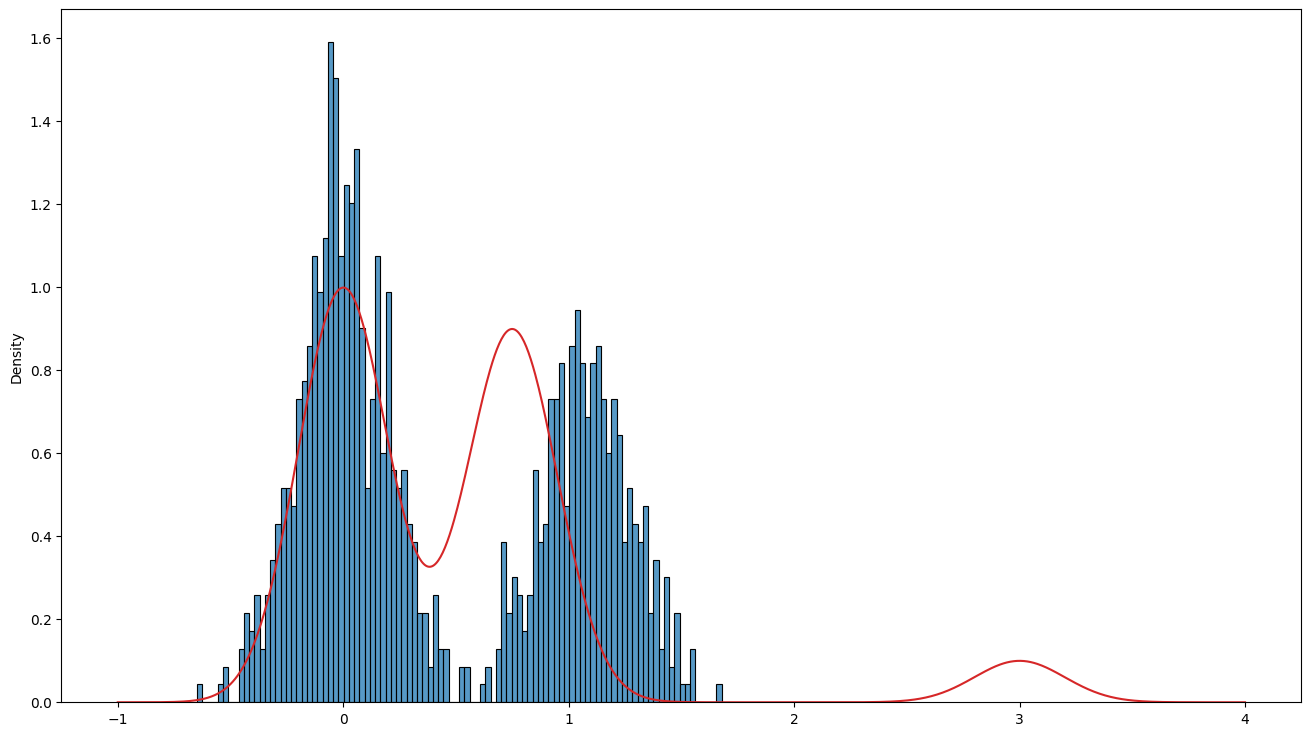

In [9]:
data_mean_hc2 = target_model(rho=np.mean(chains_hc_2['theta0']), mu=np.mean(chains_hc_2['theta1']))

plt.figure(figsize=(16, 9))

sns.histplot(data_mean_hc2, stat="density", bins=100)

x = np.linspace(-1.0, 4.0, 1000)
y = p0 * stats.norm.pdf(x, m0, sd) + p1 * stats.norm.pdf(x, m1, sd) + p2 * stats.norm.pdf(x, m2, sd)
plt.plot(x, y, color="tab:red")

plt.show()

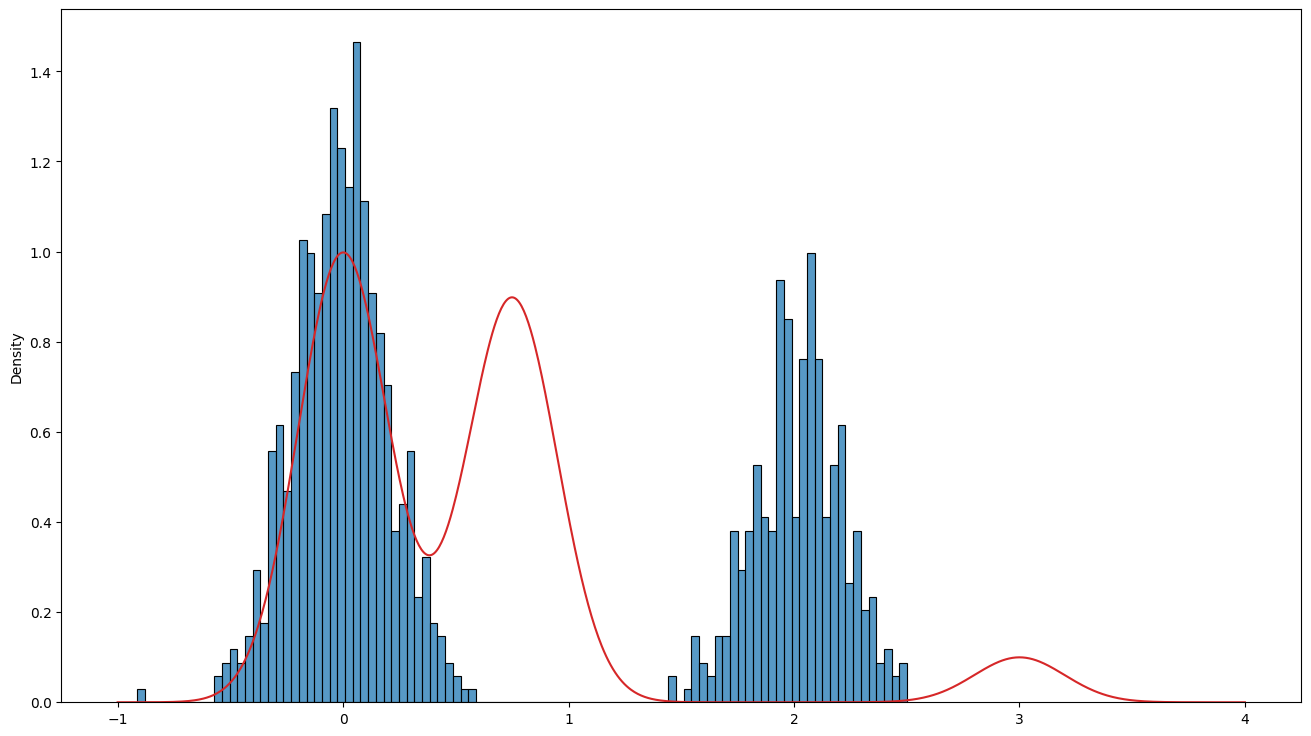

In [10]:
data_mean_no_hc = target_model(rho=np.mean(chains_no_hc['theta0']), mu=np.mean(chains_no_hc['theta1']))

plt.figure(figsize=(16, 9))

sns.histplot(data_mean_no_hc, stat="density", bins=100)

x = np.linspace(-1.0, 4.0, 1000)
y = p0 * stats.norm.pdf(x, m0, sd) + p1 * stats.norm.pdf(x, m1, sd) + p2 * stats.norm.pdf(x, m2, sd)
plt.plot(x, y, color="tab:red")

plt.show()

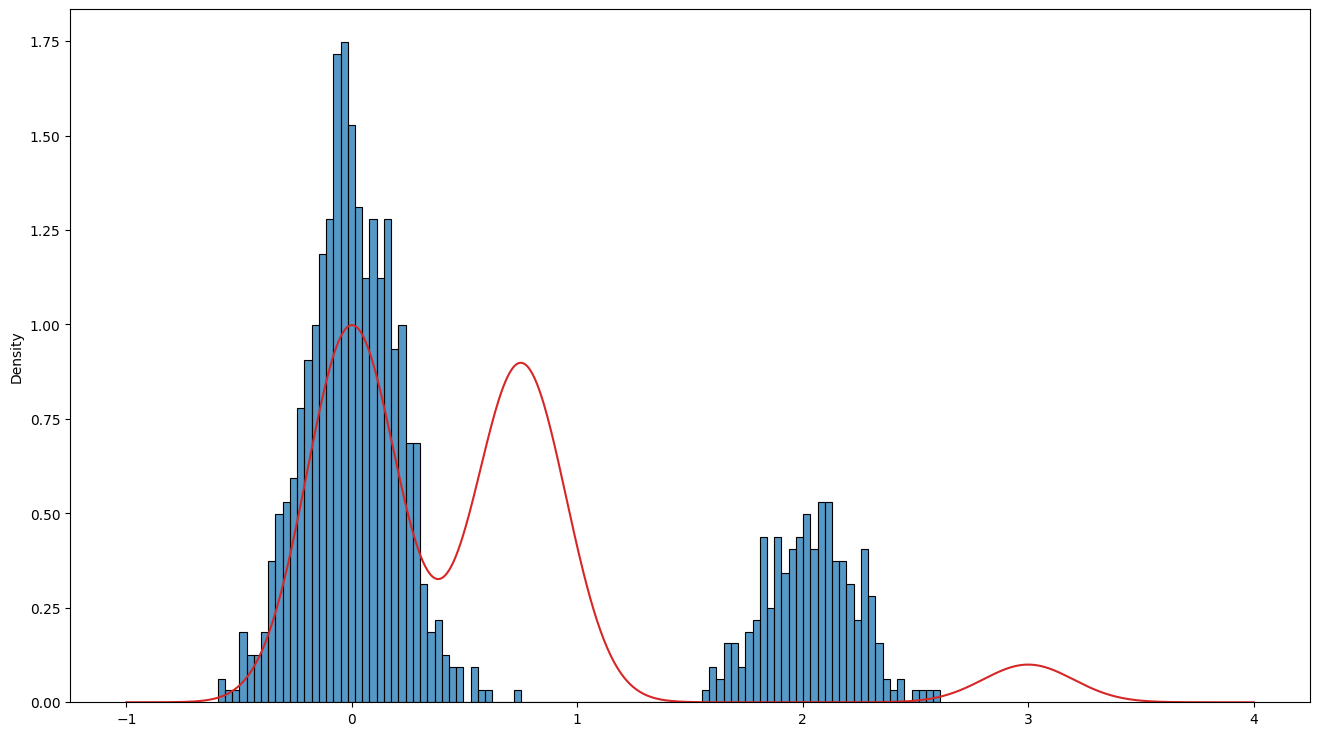

In [11]:
data_mean_hc_concat = target_model(rho=np.mean(np.concatenate((chains_hc_1['theta0'], chains_hc_2['theta0']))),
                                    mu=np.mean(np.concatenate((chains_hc_1['theta1'], chains_hc_2['theta1']))))

plt.figure(figsize=(16, 9))

sns.histplot(data_mean_hc_concat, stat="density", bins=100)

x = np.linspace(-1.0, 4.0, 1000)
y = p0 * stats.norm.pdf(x, m0, sd) + p1 * stats.norm.pdf(x, m1, sd) + p2 * stats.norm.pdf(x, m2, sd)
plt.plot(x, y, color="tab:red")

plt.show()

In [12]:
print(f"Wasserstein distance to target model with mean from hc 1:      {stats.wasserstein_distance(data, data_mean_hc1)}")
print(f"Wasserstein distance to target model with mean from hc 2:      {stats.wasserstein_distance(data, data_mean_hc2)}")
print(f"Wasserstein distance to target model with mean from concat hc: {stats.wasserstein_distance(data, data_mean_hc_concat)}")
print(f"Wasserstein distance to target model with mean from no hc:     {stats.wasserstein_distance(data, data_mean_no_hc)}")

Wasserstein distance to target model with mean from hc 1:      0.33323345839752705
Wasserstein distance to target model with mean from hc 2:      0.18721801513622374
Wasserstein distance to target model with mean from concat hc: 0.3782156557646555
Wasserstein distance to target model with mean from no hc:     0.4554235190559287


# Average distance to nearest local maximum

In [13]:
max1 = np.array([0.056, 2.97779])
max2 = np.array([0.410194, 1.12494])

rho_min = np.min([np.min(chains_hc_1["theta0"]), np.min(chains_hc_2["theta0"]), np.min(chains_no_hc["theta0"])])
rho_max = np.max([np.max(chains_hc_1["theta0"]), np.max(chains_hc_2["theta0"]), np.max(chains_no_hc["theta0"])])

mu_min = np.min([np.min(chains_hc_1["theta1"]), np.min(chains_hc_2["theta1"]), np.min(chains_no_hc["theta1"])])
mu_max = np.max([np.max(chains_hc_1["theta1"]), np.max(chains_hc_2["theta1"]), np.max(chains_no_hc["theta1"])])

def mean_dist_to_nearest_max(chains, use_norm):
    def dist(x1, y1, x2, y2):
        return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    mean = 0.0
    assert len(chains["theta0"]) == len(chains["theta1"])
    for rho, mu in zip(chains["theta0"], chains["theta1"]):
        if (use_norm):
            m1_rho = (max1[0] - rho_min) / (rho_max - rho_min)
            m1_mu  = (max1[1] - mu_min) / (mu_max - mu_min)
            m2_rho = (max2[0] - rho_min) / (rho_max - rho_min)
            m2_mu  = (max2[1] - mu_min) / (mu_max - mu_min)
            rho_norm = (rho - rho_min) / (rho_max - rho_min)
            mu_norm  = (mu - mu_min) / (mu_max - mu_min)
            mean += np.min([dist(m1_rho, rho_norm, m1_mu, mu_norm),
                            dist(m2_rho, rho_norm, m2_mu, mu_norm)])
        else:
            mean += np.min([dist(max1[0], rho, max1[1], mu),
                            dist(max2[0], rho, max2[1], mu)])
    return mean / len(chains["theta0"])

In [14]:
print("With norm:")
print(f"mean distance to nearest local maximum for hc 1:  {mean_dist_to_nearest_max(chains=chains_hc_1, use_norm=True)}")
print(f"mean distance to nearest local maximum for hc 2:  {mean_dist_to_nearest_max(chains=chains_hc_2, use_norm=True)}")
print(f"mean distance to nearest local maximum for no hc: {mean_dist_to_nearest_max(chains=chains_no_hc, use_norm=True)}")
print("Without norm:")
print(f"mean distance to nearest local maximum for hc 1:  {mean_dist_to_nearest_max(chains=chains_hc_1, use_norm=False)}")
print(f"mean distance to nearest local maximum for hc 2:  {mean_dist_to_nearest_max(chains=chains_hc_2, use_norm=False)}")
print(f"mean distance to nearest local maximum for no hc: {mean_dist_to_nearest_max(chains=chains_no_hc, use_norm=False)}")

With norm:
mean distance to nearest local maximum for hc 1:  0.6917007862165641
mean distance to nearest local maximum for hc 2:  0.2778597738404004
mean distance to nearest local maximum for no hc: 0.4142974715338698
Without norm:
mean distance to nearest local maximum for hc 1:  2.9664403559502124
mean distance to nearest local maximum for hc 2:  1.0047521756552573
mean distance to nearest local maximum for no hc: 1.883594309757976


In [15]:
print(f"hc1       = {data_mean_hc1[:10]}")
print(f"hc2       = {data_mean_hc2[:10]}")
print(f"hc_concat = {data_mean_hc_concat[:10]}")
print(f"no_hc     = {data_mean_no_hc[:10]}")

hc1       = [ 2.42745344  0.06255504 -0.03027034  0.47611125  0.17144574 -0.35455915
 -0.1258193  -0.22867638 -0.08875931  0.05586748]
hc2       = [-2.46268749e-01  9.37495602e-01  1.04774804e-01  1.12830067e+00
  1.11024322e+00  3.24004116e-01  3.26920469e-01  1.24987460e-01
 -8.88845895e-04  1.43650997e-02]
hc_concat = [-0.1326539   2.26654853  2.12836216 -0.16820368  0.24466303  0.04260599
 -0.05741914  2.26882584 -0.01896474 -0.23077783]
no_hc     = [ 1.77138787  2.07955395  0.05871246  2.19545092 -0.29343956 -0.02393665
  2.28810674  0.0484966   0.0889468  -0.4388204 ]


In [16]:
import pandas as pd

In [17]:
df = pd.DataFrame(np.array([data, data_mean_hc1, data_mean_hc2, data_mean_hc_concat, data_mean_no_hc]).T, columns=["orig_data", "hc1", "hc2", "hc_concat", "no_hc"])
# df.to_csv("../model_data.csv", index=False)